# packages

In [1]:
# Data treatment
import numpy as np
import pandas as pd
import statsmodels.api as sm

#Graphics
import matplotlib.patches as patch
import matplotlib.pyplot as plt

# Preprocessing and modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
from sklearn.svm import NuSVR
from scipy.stats import norm
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns

# Setup 
import warnings
from IPython.display import display
import time
import glob
import sys
import os
import gc
print('Load')

Load


In [2]:
# I chose fold_n to 5 for best results 
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

# The problem
In this challenge, we should help this bank identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

In this competition, The task is to predict the value of target column in the test set.

# Data

In [3]:
train_csv = '../input/santander-customer-transaction-prediction/train.csv'
test_csv = '../input/santander-customer-transaction-prediction/test.csv'
train= pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

In [4]:
sample_submission_csv = '../input/santander-customer-transaction-prediction/sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_csv)
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [5]:
train.shape, test.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [6]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.925500000000000,-6.7863,11.908099999999999,5.0930,11.460699999999999,-9.2834,5.1187,18.626600000000000,...,4.4354,3.9642,3.1364,1.691000000000000,18.522700000000000,-2.3978,7.8784,8.563499999999999,12.780300000000000,-1.091400000000000
1,train_1,0,11.500600000000000,-4.1473,13.858800000000000,5.3890,12.362200000000000,7.0433,5.6208,16.533799999999999,...,7.6421,7.7214,2.5837,10.951599999999999,15.430500000000000,2.0339,8.1267,8.788900000000000,18.356000000000002,1.951800000000000
2,train_2,0,8.609299999999999,-2.7457,12.080500000000001,7.8928,10.582500000000000,-9.0837,6.9427,14.615500000000001,...,2.9057,9.7905,1.6704,1.685800000000000,21.604199999999999,3.1417,-6.5213,8.267500000000000,14.722200000000001,0.396500000000000
3,train_3,0,11.060400000000000,-2.1518,8.952199999999999,7.1957,12.584600000000000,-1.8361,5.8428,14.925000000000001,...,4.4666,4.7433,0.7178,1.421400000000000,23.034700000000001,-1.2706,-2.9275,10.292199999999999,17.969700000000000,-8.999599999999999
4,train_4,0,9.836900000000000,-1.4834,12.874599999999999,6.6375,12.277200000000001,2.4486,5.9405,19.251400000000000,...,-1.4905,9.5214,-0.1508,9.194200000000000,13.287599999999999,-1.5121,3.9267,9.503100000000000,17.997399999999999,-8.810400000000000


In [7]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.00000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679914252000151,-1.627621689499992,10.715191851000073,6.796529157000018,11.078333240500118,-5.065317493499968,5.408948681499958,16.545849889500108,0.284161849999996,...,3.234439775999965,7.438408337000044,1.92783851400003,3.331773684500021,17.993784182999992,-0.142088433500005,2.303335243500019,8.908157683499990,15.870720248000522,-3.326536900499999
std,0.300652975806355,3.040050870668801,4.050044189955011,2.640894191799927,2.043319016359718,1.623149533936866,7.863266683476754,0.866607266216908,3.418075578937139,3.332633536717585,...,4.559921679910722,3.023271794723963,1.47842289233660,3.992030367901846,3.135161996426620,1.429372364408401,5.454369250069321,0.921625484493855,3.010945491221765,10.438015107352546
min,0.000000000000000,0.408400000000000,-15.043400000000000,2.117100000000000,-0.040200000000000,5.074800000000000,-32.562600000000003,2.347300000000000,5.349700000000000,-10.505500000000000,...,-14.093299999999999,-2.691700000000000,-3.81450000000000,-11.783400000000000,8.694400000000000,-5.261000000000000,-14.209600000000000,5.960600000000000,6.299300000000000,-38.852800000000002
25%,0.000000000000000,8.453850000000001,-4.740025000000000,8.722474999999999,5.254075000000000,9.883175000000001,-11.200350000000000,4.767700000000000,13.943800000000000,-2.317800000000000,...,-0.058825000000000,5.157400000000000,0.88977500000000,0.584600000000000,15.629799999999999,-1.170700000000000,-1.946925000000000,8.252800000000001,13.829700000000001,-11.208475000000000
50%,0.000000000000000,10.524750000000001,-1.608050000000000,10.580000000000000,6.825000000000000,11.108250000000000,-4.833150000000000,5.385100000000000,16.456800000000001,0.393700000000000,...,3.203600000000000,7.347750000000000,1.90130000000000,3.396350000000000,17.957949999999997,-0.172700000000000,2.408900000000000,8.888199999999999,15.934049999999999,-2.819550000000000
75%,0.000000000000000,12.758200000000000,1.358625000000000,12.516700000000000,8.324100000000000,12.261125000000000,0.924800000000000,6.003000000000000,19.102900000000002,2.937900000000000,...,6.406200000000000,9.512525000000000,2.94950000000000,6.205800000000000,20.396525000000000,0.829600000000000,6.556725000000000,9.593299999999999,18.064724999999999,4.836800000000000
max,1.000000000000000,20.315000000000001,10.376799999999999,19.353000000000002,13.188300000000000,16.671399999999998,17.251600000000000,8.447699999999999,27.691800000000001,10.151300000000001,...,18.440899999999999,16.716500000000000,8.40240000000000,18.281800000000000,27.928799999999999,4.272900000000000,18.321500000000000,12.000400000000001,26.079100000000000,28.500699999999998


# Reducing memory 

In [8]:
#Based on this great kernel https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",df[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",df[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df, NAlist

In [9]:
# Reducing for train data set
train, NAlist = reduce_mem_usage(train)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 308.2276611328125  MB
******************************
Column:  target
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  fl

In [10]:
# Reducing for test data set
test, NAlist = reduce_mem_usage(test)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 306.7017822265625  MB
******************************
Column:  var_0
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_1
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_2
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_3
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_4
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_5
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_6
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  var_7
dtype before:  float64
dtype after: 

# Data set fields

In [11]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [12]:
len(train.columns)

202

In [13]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), object(1), uint8(1)
memory usage: 154.3+ MB
None


In [14]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679972648620605,-1.627627611160278,10.715126037597656,6.796522617340088,11.078254699707031,-5.065340042114258,5.408960819244385,16.545988082885742,0.284159243106842,...,3.234436273574829,7.438448905944824,1.927832603454590,3.331773042678833,17.993810653686523,-0.142086714506149,2.303354501724243,8.908224105834961,15.870863914489746,-3.326541900634766
std,0.300652975806093,3.039989709854126,4.049966812133789,2.640832424163818,2.043276309967041,1.623113632202148,7.863115310668945,0.866584956645966,3.418008565902710,3.332575798034668,...,4.559854030609131,3.023208379745483,1.478387713432312,3.991934061050415,3.135113477706909,1.429340600967407,5.454273700714111,0.921603024005890,3.010892391204834,10.437831878662109
min,0.000000000000000,0.408399999141693,-15.043399810791016,2.117100000381470,-0.040199998766184,5.074800014495850,-32.562599182128906,2.347300052642822,5.349699974060059,-10.505499839782715,...,-14.093299865722656,-2.691699981689453,-3.814500093460083,-11.783399581909180,8.694399833679199,-5.261000156402588,-14.209600448608398,5.960599899291992,6.299300193786621,-38.852798461914062
25%,0.000000000000000,8.453850269317627,-4.740024805068970,8.722474813461304,5.254074931144714,9.883174657821655,-11.200350046157837,4.767700195312500,13.943799972534180,-2.317800045013428,...,-0.058825000189245,5.157400131225586,0.889775007963181,0.584599971771240,15.629799842834473,-1.170699954032898,-1.946925014257431,8.252799987792969,13.829700469970703,-11.208474636077881
50%,0.000000000000000,10.524750232696533,-1.608050048351288,10.579999923706055,6.824999809265137,11.108250141143799,-4.833149909973145,5.385099887847900,16.456800460815430,0.393700003623962,...,3.203599929809570,7.347749948501587,1.901299953460693,3.396350026130676,17.957949638366699,-0.172700002789497,2.408900022506714,8.888199806213379,15.934050083160400,-2.819550037384033
75%,0.000000000000000,12.758199691772461,1.358625024557114,12.516699790954590,8.324099540710449,12.261124849319458,0.924799978733063,6.002999782562256,19.102899551391602,2.937900066375732,...,6.406199932098389,9.512524843215942,2.949500083923340,6.205800056457520,20.396524906158447,0.829599976539612,6.556725144386292,9.593299865722656,18.064724445343018,4.836800098419189
max,1.000000000000000,20.315000534057617,10.376799583435059,19.353000640869141,13.188300132751465,16.671400070190430,17.251600265502930,8.447699546813965,27.691799163818359,10.151300430297852,...,18.440900802612305,16.716499328613281,8.402400016784668,18.281799316406250,27.928800582885742,4.272900104522705,18.321500778198242,12.000399589538574,26.079099655151367,28.500699996948242


# Visualization

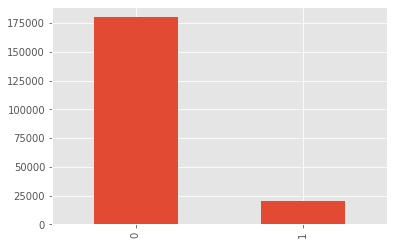

In [15]:
#histogram
train['target'].value_counts().plot.bar();

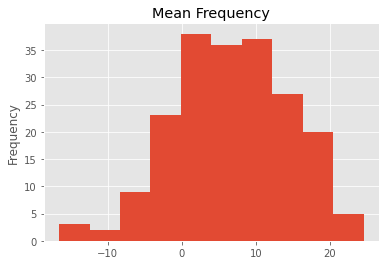

In [16]:
#Mean Frequency

train_mean = train[train.columns[2:]].mean()
train_mean.plot(kind = 'hist');plt.title('Mean Frequency');

**The frequency distribution of var_0**

In [17]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return np.concatenate([x[0:N-1], (cumsum[N:] - cumsum[:-N]) / N])

var = 'var_0' #feat we are going to analyse
mydf = train.copy() #df we are going to analyze

def df_to_bin(var, mydf):
    IQR = mydf[var].quantile([0.75]).values - mydf[var].quantile([0.25]).values #inter-quartile range
    n = 200000 #size of our dataframe
    bin_size = 2.5*IQR/n**(1/3) #Freedman-Diaconis rule to define the bin size
    bin_number = int((mydf[var].max() - mydf[var].min())/bin_size)
    
    #creat new feature based on the bins
    mydf['new' + var] = pd.cut(mydf[var], bins = bin_number, labels = range(bin_number)).astype('float')

    #separate dfs betweens target ==0 and target == 1
    df_no_transfer = mydf['new' + var][mydf['target'] == 0].value_counts().sort_index()
    #get the bin frequency height (H) and the index of that bin (X)
    H0,X0 = list(df_no_transfer.values), list(df_no_transfer.index) 

    df_with_transfer = mydf['new' + var][mydf['target'] == 1].value_counts().sort_index()
    H1,X1 = list(df_with_transfer.values), list(df_with_transfer.index) 
    
    #If there are any bins with 0 frequency between 0 and the total number of bins, lets put it in our list
    for i in range(bin_number):
        if i not in X0:
            H0.append(0)
            X0.append(i)

        if i not in X1:
            H1.append(0)
            X1.append(i)

    #sort the bins so the list index == bin number
    H0 = [h for _,h in sorted(zip(X0,H0))]
    X0 = [x for x,_ in sorted(zip(X0,H0))]
    H1 = [h for _,h in sorted(zip(X1,H1))]
    X1 = [x for x,_ in sorted(zip(X1,H1))]

    H0 = running_mean(H0, 2)  
    H1 = running_mean(H1, 2)  
    Hsum = H0 + H1
    
    return bin_size, bin_number, mydf, H0, H1, Hsum, X0, X1

var = 'var_0'
bin_size, bin_number, mydf, H0, H1, Hsum, X0, X1 = df_to_bin(var, train)

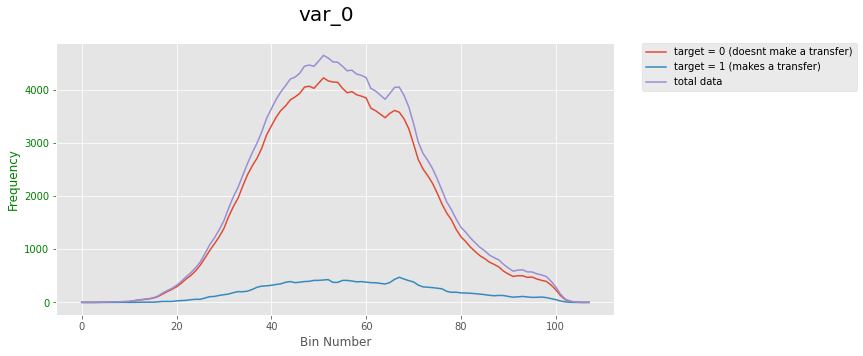

In [18]:
#plot the result
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(H0, label='target = 0 (doesnt make a transfer)')
ax1.plot(H1, label='target = 1 (makes a transfer)')
ax1.plot(Hsum, label='total data')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
fig.suptitle(var, fontsize=20)
ax1.set_ylabel('Frequency', color='g', fontsize=12)
ax1.tick_params(axis='y', colors='green')
plt.xlabel('Bin Number', fontsize=12)
plt.show()

* In blue you can see the distribution of the clients that make a transfer.
* In red it is the distribution of the clients that do not make a transfer.
* And finally, in purple, it is the total distribution

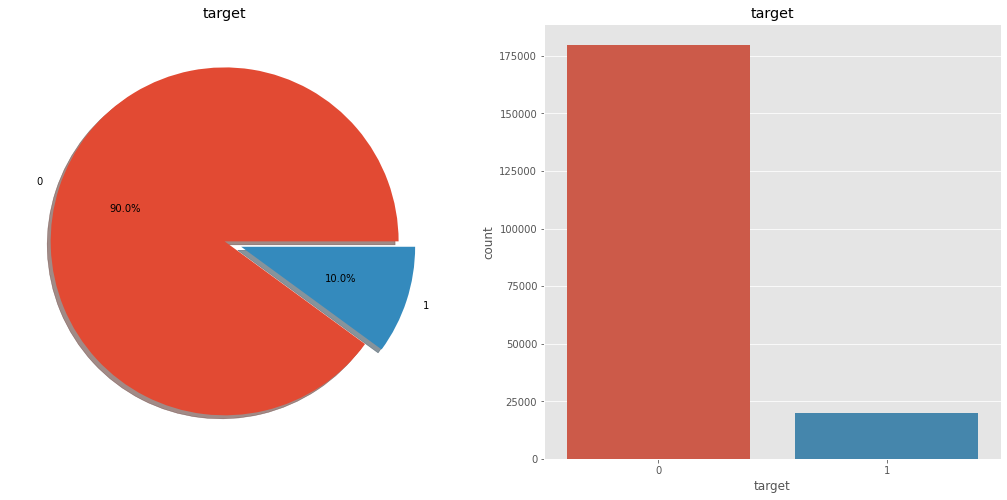

In [19]:
#countplot
f, ax = plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('target')
ax[0].set_ylabel('')
sns.countplot('target',data=train,ax=ax[1])
ax[1].set_title('target')
plt.show()

# Check histogram for all feature

Distributions of first 28 columns


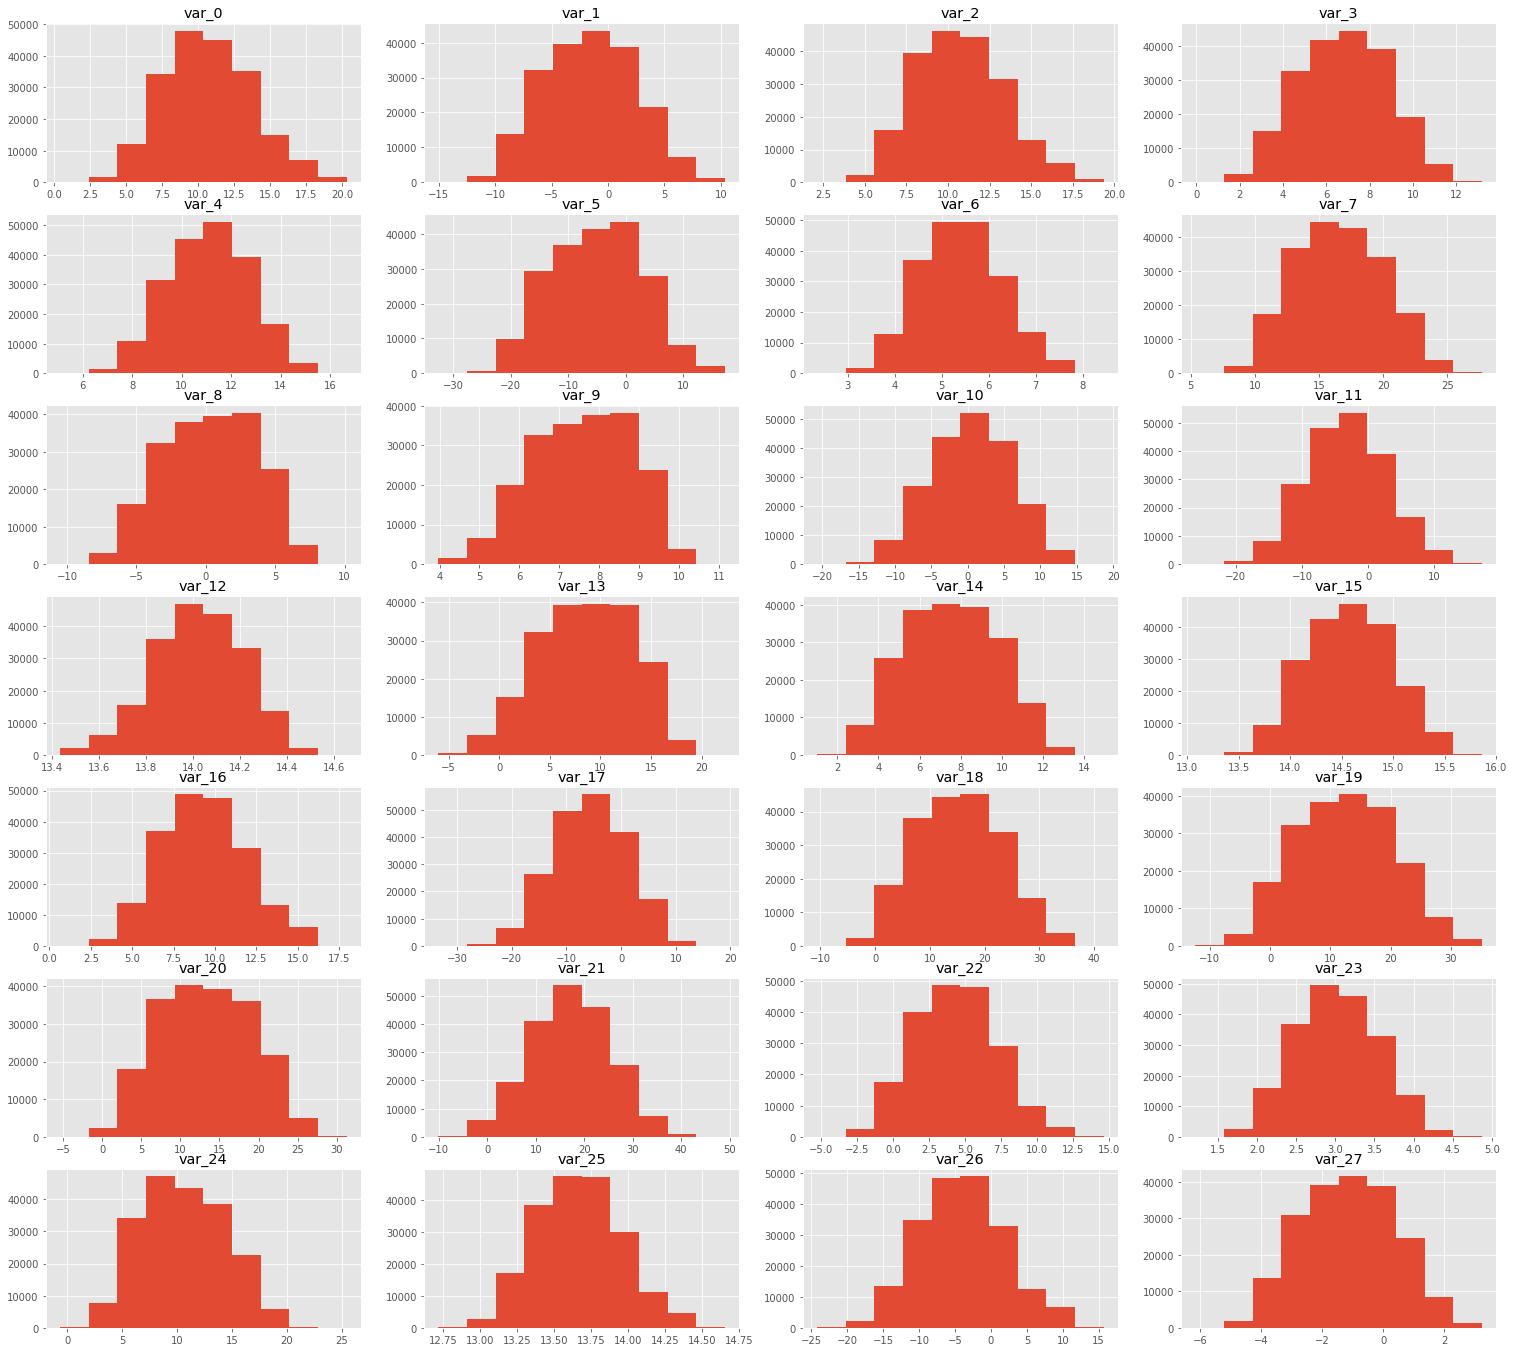

In [20]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(train[col])
    plt.title(col)

<AxesSubplot:xlabel='target', ylabel='var_0'>

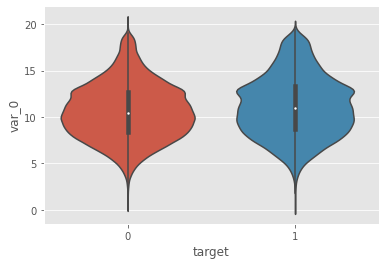

In [21]:
#violinplot
sns.violinplot(data=train,x="target",y="var_0")

<AxesSubplot:xlabel='target', ylabel='var_50'>

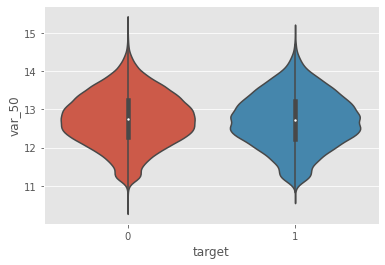

In [22]:
sns.violinplot(data=train,x="target",y="var_50")

<AxesSubplot:xlabel='target', ylabel='var_100'>

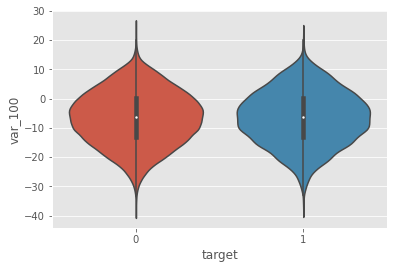

In [23]:
sns.violinplot(data=train,x="target", y="var_100")

# Data Preprocessing

In [24]:
# Check missing data
train.isnull().any().any()

False

In [25]:
# Check missing data
test.isnull().any().any()

False

In [26]:
# Binary Classification
train['target'].unique()

array([0, 1], dtype=uint8)

## Is data set imbalance?

In [27]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [28]:
def check_balance(df,target):
    check=[]
    # for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('for target',str(i), ": ", df[target].value_counts()[i]/df.shape[0]*100,'%')

In [29]:
check_balance(train,'target')

size of data is: 200000
for target 0 :  89.95100000000001 %
for target 1 :  10.049 %


# skewness and kurtosis

In [30]:
print("Skewness: %f" % train['target'].skew())
print("Kurtosis: %f" % train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


In [31]:
corrs = train.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
40592,target,var_6,0.066730845204628
40593,var_6,target,0.066730845204628
40594,target,var_12,0.069489276632683
40595,var_12,target,0.069489276632683
40596,target,var_139,0.074079632714559
40597,var_139,target,0.074079632714559
40598,var_81,target,0.080917332251442
40599,target,var_81,0.080917332251442
40600,var_0,newvar_0,0.999847153982211
40601,newvar_0,var_0,0.999847153982211


# Model

In [32]:
"""
#Prepare our data for our model
cols=["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]
"""

'\n#Prepare our data for our model\ncols=["target","ID_code"]\nX = train.drop(cols,axis=1)\ny = train["target"]\n'

In [33]:
X = train.drop(["target","ID_code","newvar_0"],axis=1)
y = train["target"]

In [34]:
X_test  = test.drop("ID_code",axis=1)

In [35]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

# calculate and show importances

In [36]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [37]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

Weight,Feature
0.0000 ± 0.0000,var_99
0.0000 ± 0.0000,var_184
0.0000 ± 0.0000,var_174
0.0000 ± 0.0000,var_166
0.0000 ± 0.0000,var_154
0.0000 ± 0.0000,var_12
0.0000 ± 0.0000,var_133
0.0000 ± 0.0000,var_145
0.0000 ± 0.0000,var_140
0.0000 ± 0.0000,var_139


# Partial Dependence Plots

In [38]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

For the sake of explanation, I use a Decision Tree which you can see below.

In [39]:
features = [c for c in train.columns if c not in ['ID_code', 'target',"newvar_0"]]

In [40]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

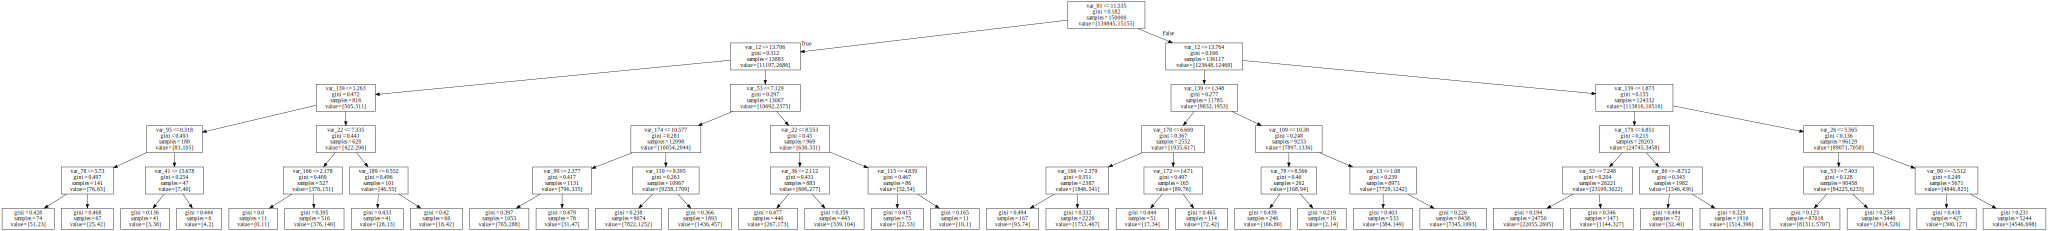

In [41]:
graphviz.Source(tree_graph)

# Partial Dependence Plot.
In this section, we see the impact of the main variables discovered in the previous sections by using the pdpbox.

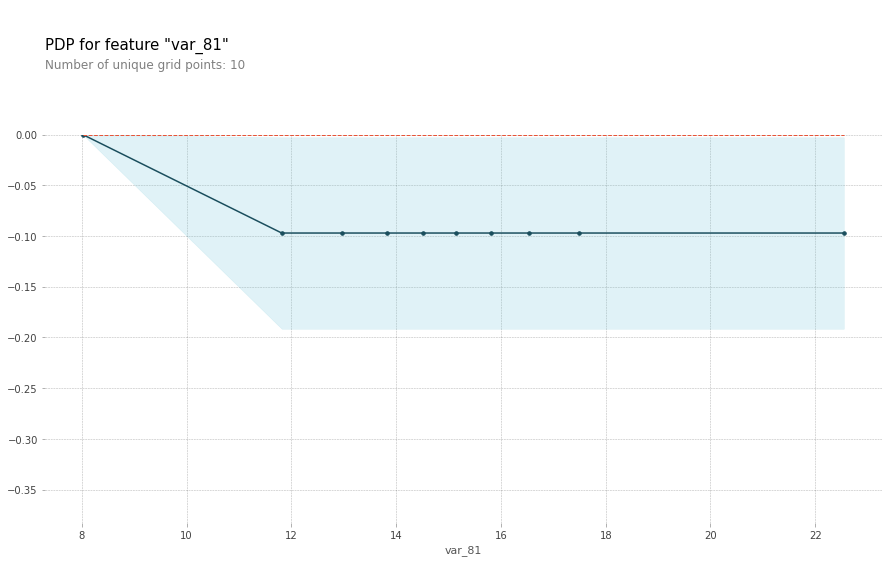

In [42]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

# plot it
pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

# Chart analysis

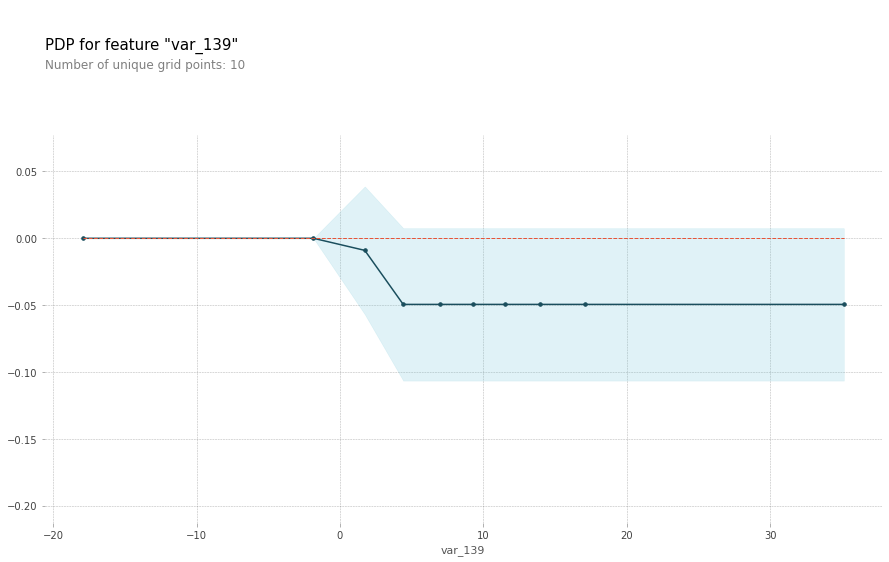

In [43]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_139')

# plot it
pdp.pdp_plot(pdp_goals, 'var_139')
plt.show()

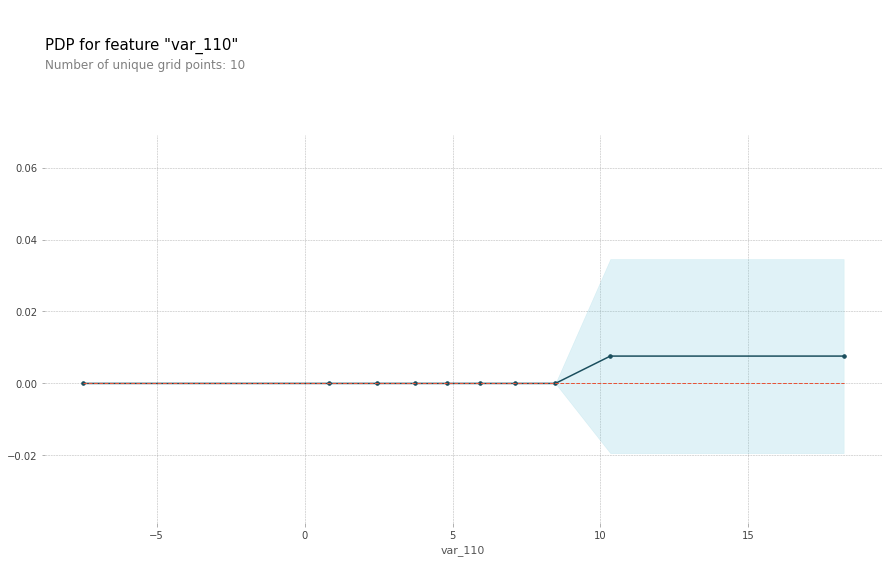

In [44]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

# plot it
pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

# **Model Development**

   # lightgbm

In [45]:
params1 = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"auc",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 13,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}

In [46]:
%%time
pred_lgb = np.zeros(len(X_test))
num_round = 1000000

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train_lgb, X_valid_lgb = X.iloc[train_index], X.iloc[valid_index]
    y_train_lgb, y_valid_lgb = y.iloc[train_index], y.iloc[valid_index]
    
    train_lgb = lgb.Dataset(X_train_lgb, label=y_train_lgb)
    valid_lgb = lgb.Dataset(X_valid_lgb, label=y_valid_lgb)
    
    lgb_model = lgb.train(params1, train_lgb, num_round,
                          valid_sets=[train_lgb,valid_lgb], verbose_eval=1000, early_stopping_rounds = 3000)
    
    pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Fri Feb 18 00:44:26 2022
[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 200
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.889373	valid_1's auc: 0.86946
[2000]	training's auc: 0.907674	valid_1's auc: 0.88395
[3000]	training's auc: 0.918192	valid_1's auc: 0.890538
[4000]	training's auc: 0.925602	valid_1's auc: 0.894166
[5000]	training's auc: 0.931453	valid_1's auc: 0.896143
[6000]	training's auc: 0.936545	valid_1's auc: 0.897452
[7000]	training's auc: 0.941064	valid_1's auc: 0.898251
[8000]	training's auc: 0.945207	valid_1's auc: 0.898635
[9000]	training's auc: 0.949133	valid_1's auc: 0.899024
[10000]	training's auc: 0

In [47]:
params2 = {'learning_rate':0.06,
           'max_bin': 165,
           'max_depth': 5,
           'min_child_samples': 153,
           'min_child_weight': 0.1,
           'min_split_gain': 0.0018,
           'n_estimators': 41,
           'num_leaves': 6,
           'reg_alpha': 2.1,
           'reg_lambda': 2.54,
           'objective': "binary",
           'n_jobs': -1}

In [48]:
%%time
y_pred_lgb = np.zeros(len(X_test))
num_round = 1000000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
        
    lgb_model = lgb.train(params2,train_data,num_round,
                    valid_sets = [train_data, valid_data],verbose_eval=1000,early_stopping_rounds = 3500)
            
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Fri Feb 18 01:33:15 2022
[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.357315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33000
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 200
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100494 -> initscore=-2.191750
[LightGBM] [Info] Start training from score -2.191750
Training until validation scores don't improve for 3500 rounds
Did not meet early stopping. Best iteration is:
[41]	training's binary_logloss: 0.297452	valid_1's binary_logloss: 0.299007
Fold 1 started at Fri Feb 18 01:33:25 2022
[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.352348 seconds.
You can set `force_col_wise=true` to remove the

   ## RandomForestClassifier

In [49]:
y_pred_rfc = rfc_model.predict(X_test)

## DecisionTreeClassifier

In [50]:
pred_tree = tree_model.predict(X_test)

## CatBoostClassifier

In [51]:
train_pool = Pool(train_X,train_y)
cat_model = CatBoostClassifier(
                               iterations=3000,# change 25 to 3000 to get best performance 
                               learning_rate=0.03,
                               objective="Logloss",
                               eval_metric='AUC',
                              )
cat_model.fit(train_X,train_y,silent=True)
y_pred_cat = cat_model.predict(X_test)

In [52]:
submission_rfc = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_rfc
    })
submission_rfc.to_csv('submission_rfc.csv', index=False)

In [53]:
submission_tree = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_tree
    })
submission_tree.to_csv('submission_tree.csv', index=False)

NameError: name 'y_pred_tree' is not defined

In [ ]:
submission_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_cat
    })
submission_cat.to_csv('submission_cat.csv', index=False)

In [ ]:
# good for submit
submission_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": y_pred_lgb
    })
submission_lgb.to_csv('submission_lgb.csv', index=False)

## Combine

In [ ]:
submission_rfc_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_cat)/2
    })
submission_rfc_cat.to_csv('submission_rfc_cat.csv', index=False)

submission_lgb_cat = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_lgb +y_pred_cat)/2
    })
submission_lgb_cat.to_csv('submission_lgb_cat.csv', index=False)

submission_rfc_lgb = pd.DataFrame({
        "ID_code": test["ID_code"],
        "target": (y_pred_rfc +y_pred_lgb)/2
    })
submission_rfc_lgb.to_csv('submission_rfc_lgb.csv', index=False)